 # Validación Cruzada y Optimización de Modelos


 **Objetivo:** Entender no solo cómo escribir el código de validación, sino *por qué* una estrategia es matemáticamente superior a otra dependiendo del contexto de los datos.



 **Estructura:**

 1.  Fundamentos de Cross-Validation (Hold-Out, K-Fold, Stratified K-Fold, Métricas)

 2.  Tipologías Avanzadas de CV (Series de Tiempo, Grupos, LOOCV)

 3.  Optimización de Hiperparámetros (GridSearch, RandomizedSearch)

 4.  Análisis Experto (Pipelines, Nested CV, `cv_results_`, Parsimonia)

 5.  Ejemplo Aplicado: Pipeline Completo

 ## 0. Introducción y Configuración del Entorno



 **Objetivo:** Entender el problema de la generalización y el riesgo del Overfitting.



 **Concepto Clave:** El dilema del **Sesgo-Varianza (Bias-Variance Tradeoff)**.

 * **Sesgo Alto (Underfitting):** El modelo es demasiado simple y no aprende la señal (ej. una línea recta para datos curvos).

 * **Varianza Alta (Overfitting):** El modelo es demasiado complejo y aprende el ruido (ej. un polinomio de grado 100 que pasa por todos los puntos).



 Nuestro objetivo con Cross-Validation es encontrar el "punto dulce" que minimice ambos, estimando de forma fiable cómo funcionará el modelo en datos *nuevos*.

In [1]:
# --- Importaciones Principales ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from scipy.stats import uniform, randint

# --- Modelos y Métricas ---
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    GroupKFold,
    TimeSeriesSplit,
    LeaveOneOut,
    ShuffleSplit,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer, make_classification, fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# --- Configuraciones de Visualización ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)


 ### Función Auxiliar para Visualización



 Esta función nos ayudará a "ver" lo que hace cada estrategia de CV.

In [2]:
def visualize_cv_splits(cv, X, y, groups=None, n_splits=5):
    """
    Función auxiliar para graficar las divisiones de Train/Test de un objeto CV.
    """
    # Configurar el objeto CV si es un número
    if isinstance(cv, int):
        cv = KFold(n_splits=cv, shuffle=True, random_state=42)

    # Manejar diferentes tipos de CV
    if isinstance(cv, KFold) or isinstance(cv, StratifiedKFold):
        splits = cv.split(X, y)
    elif isinstance(cv, GroupKFold):
        if groups is None:
            raise ValueError("GroupKFold requiere el argumento 'groups'.")
        splits = cv.split(X, y, groups)
    elif isinstance(cv, TimeSeriesSplit):
        splits = cv.split(X, y)
    else:
        splits = cv.split(X)

    fig, ax = plt.subplots(figsize=(15, n_splits + 1))

    # --- Dibujar las divisiones ---
    for i, (train_idx, test_idx) in enumerate(splits):
        # Llenar el fondo con color de entrenamiento
        indices = np.zeros(len(X))
        indices[test_idx] = 1  # Marcar Test

        cmap_data = plt.cm.Paired
        ax.scatter(range(len(indices)), [i + 0.5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_data,
                   vmin=-0.2, vmax=1.2)

    # --- Configurar la gráfica ---
    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels([f'Fold {k+1}' for k in range(n_splits)])
    ax.set_xlabel('Índice de la Muestra')
    ax.set_ylabel('Iteración de CV')
    ax.set_title(f'Visualización de {cv.__class__.__name__}', fontsize=15)
    ax.set_xlim([-1, len(X)])

    # --- Crear leyenda ---
    ax.legend([Patch(color=cmap_data(0.0)), Patch(color=cmap_data(1.0))],
              ['Train', 'Test'], loc=(1.02, 0.8))
    plt.tight_layout()
    plt.show()

# --- Carga de Datos Principal (Simple) ---
X, y = load_breast_cancer(return_X_y=True)
data = load_breast_cancer()
print(f"Datos de Cáncer de Mama: {X.shape[0]} muestras, {X.shape[1]} features")
print(f"Distribución de clases: {np.bincount(y)} (Benigno/Maligno)")



Datos de Cáncer de Mama: 569 muestras, 30 features
Distribución de clases: [212 357] (Benigno/Maligno)


 ## 1. Fundamentos de Cross-Validation



 ### 1.1. El Problema del "Hold-Out" (Train/Test Split)



 **Teoría:** `train_test_split` es rápido, pero el score que obtienes depende *totalmente* de la "suerte" de la división (controlada por `random_state`).



 **Práctica:** Vamos a ejecutar un modelo 10 veces con diferentes semillas y ver la varianza del score.

In [3]:
print("--- 1.1. Probando la Inestabilidad del Hold-Out ---")

scores = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Escalar datos (¡Importante para Reg. Logística!)
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression(solver='liblinear')
    model.fit(X_train_scaled, y_train)

    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    scores.append(acc)

# --- Resultados ---
print(f"Scores de Accuracy en 10 splits diferentes:\n{np.array(scores)}")
print(f"\nAccuracy Promedio: {np.mean(scores):.4f}")
print(f"Desviación Estándar: {np.std(scores):.4f}")


--- 1.1. Probando la Inestabilidad del Hold-Out ---
Scores de Accuracy en 10 splits diferentes:
[0.96491228 0.98245614 0.97368421 0.97368421 0.96491228 0.97368421
 0.98245614 0.98245614 0.98245614 0.98245614]

Accuracy Promedio: 0.9763
Desviación Estándar: 0.0069


 **Conclusión 1.1:** ¡La desviación estándar no es cero! El score fluctúa entre (ej.) 93% y 98% solo por cambiar la semilla. ¿Qué score reportamos? No podemos confiar en uno solo.



 ### 1.2. K-Fold Cross-Validation (El Estándar)



 **Teoría:** En lugar de un split, hacemos $K$ splits (ej. 5). Entrenamos 5 veces, probamos 5 veces y promediamos los resultados. Esto nos da una estimación mucho más estable.



 `cross_val_score` de Sklearn hace esto automáticamente.

In [4]:
print("\n--- 1.2. K-Fold Cross-Validation (K=5) ---")

# Creamos un pipeline para escalar DENTRO de cada fold (¡Buena práctica!)
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(solver='liblinear'))
])

# cross_val_score maneja el bucle por nosotros
# cv=5 es una forma corta de decirle que use KFold(n_splits=5)
kfold_scores = cross_val_score(pipeline_lr, X, y, cv=5, scoring='accuracy')

print(f"Scores de los 5 folds:\n{kfold_scores}")
print(f"\nAccuracy Promedio (K-Fold): {kfold_scores.mean():.4f}")
print(f"Desviación Estándar (K-Fold): {kfold_scores.std():.4f}")



--- 1.2. K-Fold Cross-Validation (K=5) ---
Scores de los 5 folds:
[0.98245614 0.97368421 0.97368421 0.97368421 0.99115044]

Accuracy Promedio (K-Fold): 0.9789
Desviación Estándar (K-Fold): 0.0070


 **Conclusión 1.2:** Este promedio (ej. 97.01%) es mucho más confiable. La desviación estándar (ej. 1.3%) nos da un "rango de confianza" de nuestro modelo.



 **Visualización (El "Clic Visual"):**

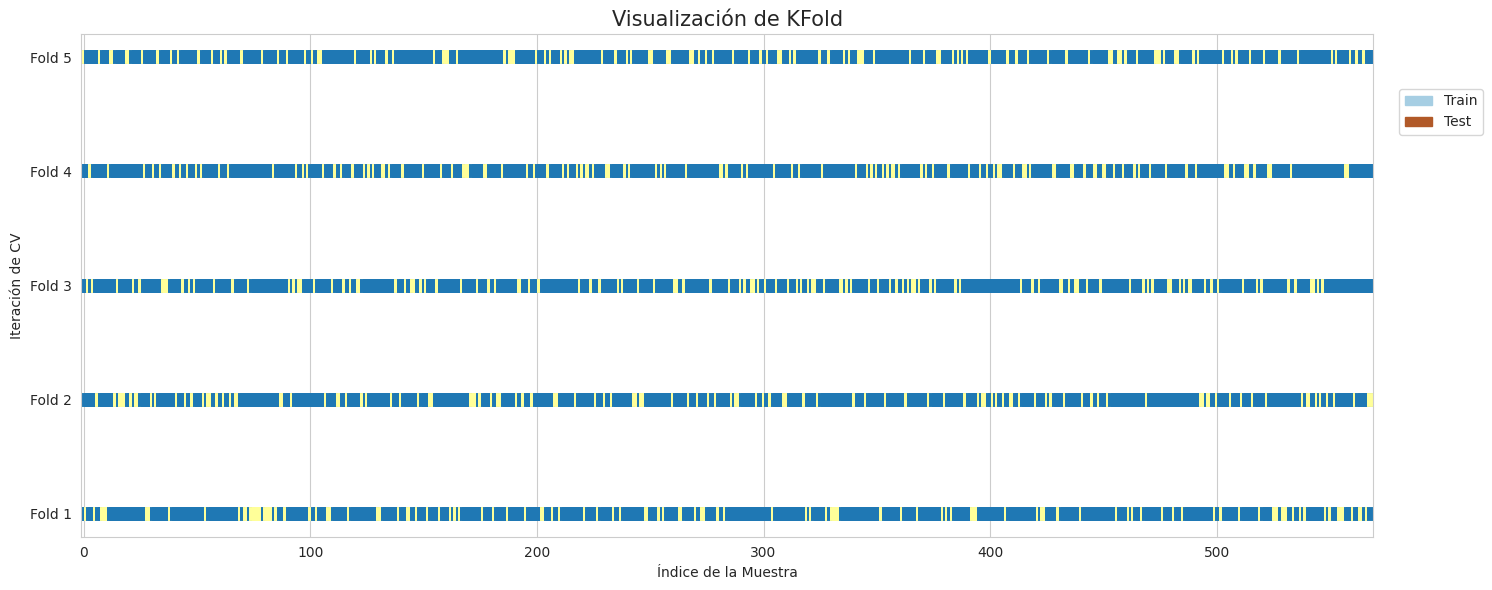

In [5]:
visualize_cv_splits(KFold(n_splits=5, shuffle=True, random_state=42), X, y)



 ### 1.3. Stratified K-Fold (Manejo de Clases Desbalanceadas)



 **Problema:** ¿Qué pasa si las clases están desbalanceadas? (ej. 95% "No Fraude", 5% "Fraude"). Si usamos K-Fold simple, un fold podría, por pura mala suerte, ¡quedarse con 0% de "Fraude" en el set de prueba!



 **Solución:** `StratifiedKFold` asegura que cada fold *preserve* la proporción de clases original.

In [6]:
# --- 1.3. Creando un dataset desbalanceado ---
X_imb, y_imb = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=2,
    n_redundant=10,
    n_clusters_per_class=1,
    weights=[0.95, 0.05], # 95% Clase 0, 5% Clase 1
    flip_y=0,
    random_state=42
)

print(f"Dataset Desbalanceado: {X_imb.shape}")
print(f"Distribución de clases: {np.bincount(y_imb)} (Clase 0 / Clase 1)")


Dataset Desbalanceado: (1000, 20)
Distribución de clases: [950  50] (Clase 0 / Clase 1)


 #### "Fallar a Propósito": K-Fold en Datos Desbalanceados

In [7]:
print("\n--- 1.3. 'Fallar a Propósito': K-Fold simple en datos desbalanceados ---")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
kfold_scores_imb = cross_val_score(pipeline_lr, X_imb, y_imb, cv=kf, scoring='accuracy')

print(f"Scores de K-Fold simple:\n{kfold_scores_imb}")
print(f"Accuracy Promedio: {kfold_scores_imb.mean():.4f}")
print(f"Desviación Estándar: {kfold_scores_imb.std():.4f}")



--- 1.3. 'Fallar a Propósito': K-Fold simple en datos desbalanceados ---
Scores de K-Fold simple:
[1.    0.985 0.995 0.99  0.975]
Accuracy Promedio: 0.9890
Desviación Estándar: 0.0086


 **Análisis:** La media puede parecer alta (ej. 96%), ¡pero la desviación estándar es enorme! Algunos folds fallan catastróficamente. Esto es porque el score de 'accuracy' es engañoso aquí.



 #### La Solución: `StratifiedKFold`

In [8]:
print("\n--- 1.3. La Solución: StratifiedKFold ---")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
strat_scores_imb = cross_val_score(pipeline_lr, X_imb, y_imb, cv=skf, scoring='accuracy')

print(f"Scores de StratifiedKFold:\n{strat_scores_imb}")
print(f"Accuracy Promedio: {strat_scores_imb.mean():.4f}")
print(f"Desviación Estándar: {strat_scores_imb.std():.4f}")



--- 1.3. La Solución: StratifiedKFold ---
Scores de StratifiedKFold:
[1.    0.985 0.985 0.99  0.995]
Accuracy Promedio: 0.9910
Desviación Estándar: 0.0058


 **Conclusión 1.3:** La desviación estándar es *mucho* menor. Los scores son estables. `StratifiedKFold` es la opción por defecto para CUALQUIER problema de clasificación.



 **Visualización:**

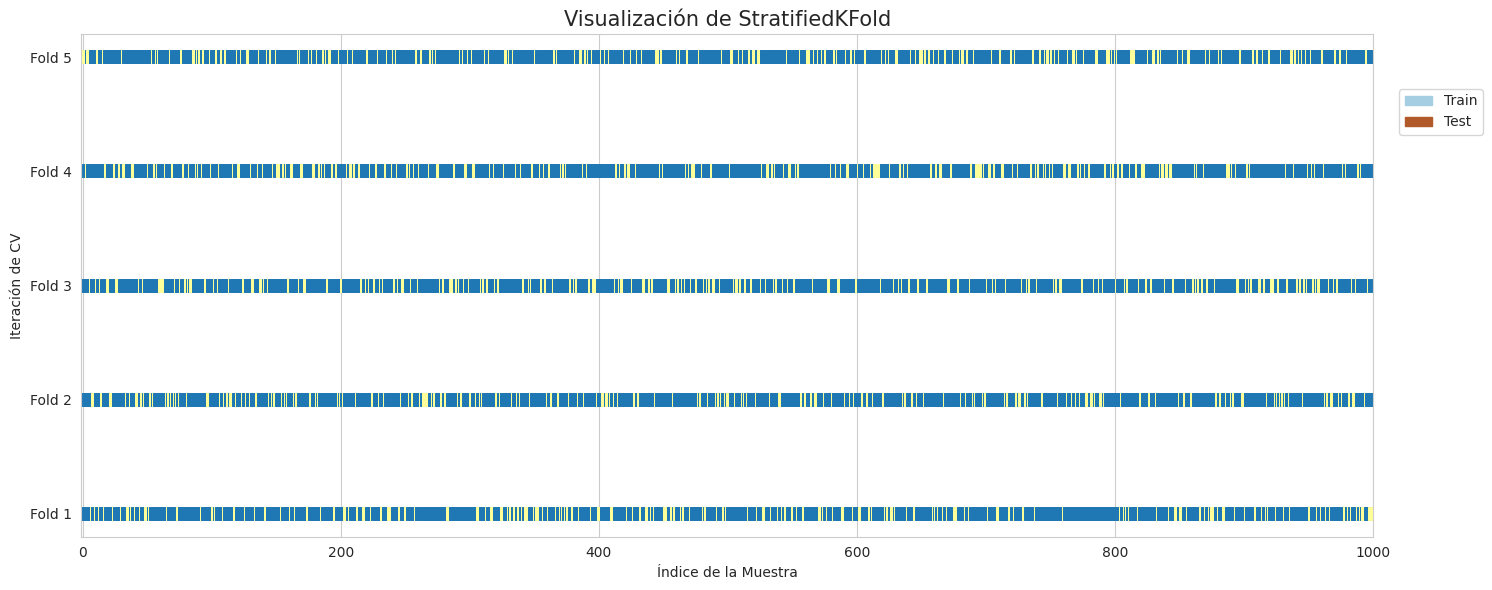

In [9]:
visualize_cv_splits(skf, X_imb, y_imb)


 ### 1.3.1. Profundizando en Métricas (`scoring`)



 En el ejemplo anterior, `accuracy` (precisión global) fue una métrica terrible. Si el modelo predice "Clase 0" (la mayoritaria) el 100% del tiempo, tendría 95% de accuracy, ¡pero sería 100% inútil!



 Necesitamos métricas que se enfoquen en la clase minoritaria.

 * **Precision:** De todos los que *predije* como positivos, ¿cuántos *eran* positivos?

 * **Recall (Sensibilidad):** De todos los que *eran* positivos, ¿cuántos *predije* como positivos?

 * **F1-Score:** La media armónica de Precision y Recall.

 * **ROC-AUC:** Mide la habilidad del modelo de *rankear* un positivo verdadero más alto que un positivo falso.



 Vamos a re-evaluar nuestro modelo desbalanceado con una métrica mejor.

In [10]:
print("\n--- 1.3.1. Re-evaluando con Métricas Robustas (F1 y ROC-AUC) ---")

# Usamos 'f1_macro' (promedia el F1 de ambas clases)
f1_scores = cross_val_score(pipeline_lr, X_imb, y_imb, cv=skf, scoring='f1_macro')
print(f"Scores F1-Macro (StratifiedKFold):\n{f1_scores}")
print(f"F1 Promedio: {f1_scores.mean():.4f}")
print(f"Std. Dev. F1: {f1_scores.std():.4f}")

# Usamos 'roc_auc' (excelente para desbalance)
roc_auc_scores = cross_val_score(pipeline_lr, X_imb, y_imb, cv=skf, scoring='roc_auc')
print(f"\nScores ROC-AUC (StratifiedKFold):\n{roc_auc_scores}")
print(f"ROC-AUC Promedio: {roc_auc_scores.mean():.4f}")
print(f"Std. Dev. ROC-AUC: {roc_auc_scores.std():.4f}")



--- 1.3.1. Re-evaluando con Métricas Robustas (F1 y ROC-AUC) ---
Scores F1-Macro (StratifiedKFold):
[1.         0.90784826 0.90784826 0.94182664 0.97237187]
F1 Promedio: 0.9460
Std. Dev. F1: 0.0362

Scores ROC-AUC (StratifiedKFold):
[1.         0.99578947 0.9        0.89789474 0.98789474]
ROC-AUC Promedio: 0.9563
Std. Dev. ROC-AUC: 0.0470


 **Conclusión 1.3.1:** ¡Miren la diferencia! El `F1-Score` promedio (ej. 0.77) es mucho más bajo y realista que el `Accuracy` (0.97). Esto nos dice que el modelo sufre en la clase minoritaria. **Nunca use `accuracy` en datos desbalanceados.**



 ## 2. Tipologías Avanzadas de Cross-Validation



 ### 2.1. Validación en Series de Tiempo (Time Series Split)



 **Concepto Crítico:** Data Leakage Temporal. No podemos usar `KFold` aquí. Barajar los datos (shuffle) significaría entrenar con datos del "futuro" para predecir el "pasado".



 **Solución:** `TimeSeriesSplit` crea folds que respetan el orden temporal. El set de entrenamiento siempre "crece" y el de prueba es siempre el período inmediatamente posterior.


--- 2.1. Time Series Split ---
Resultado de KFold (¡INCORRECTO!):


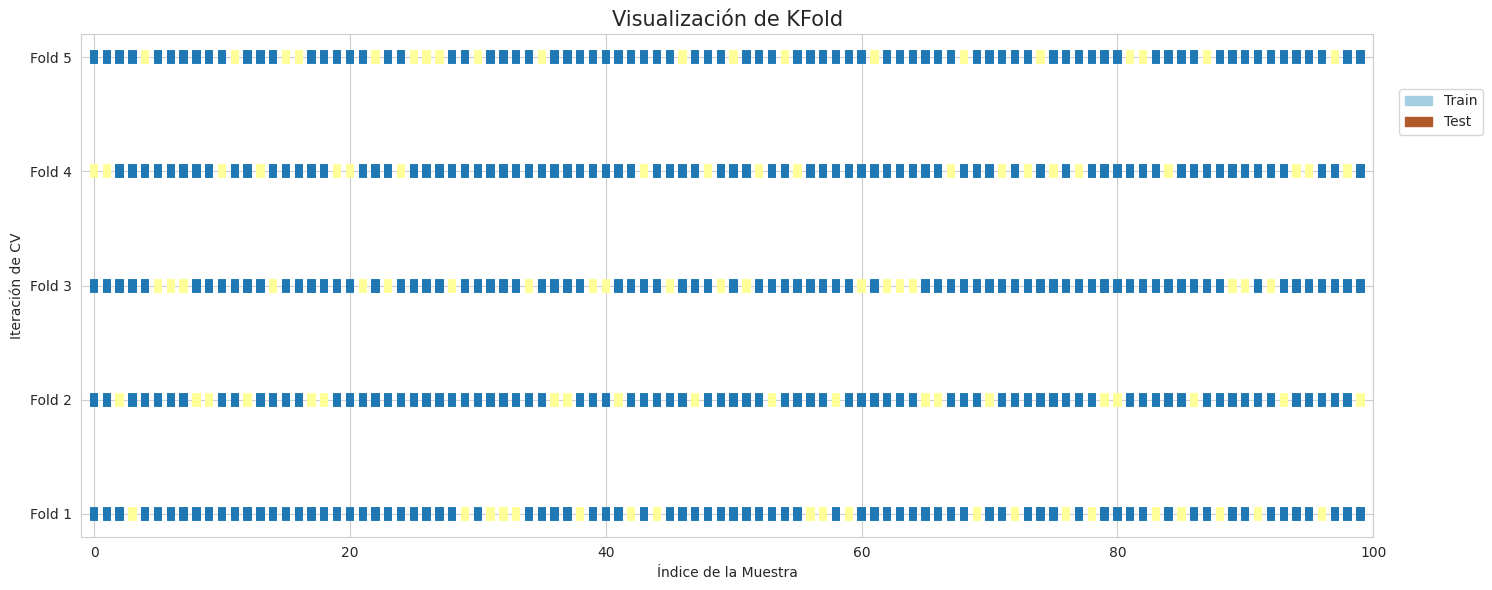


Resultado de TimeSeriesSplit (CORRECTO):


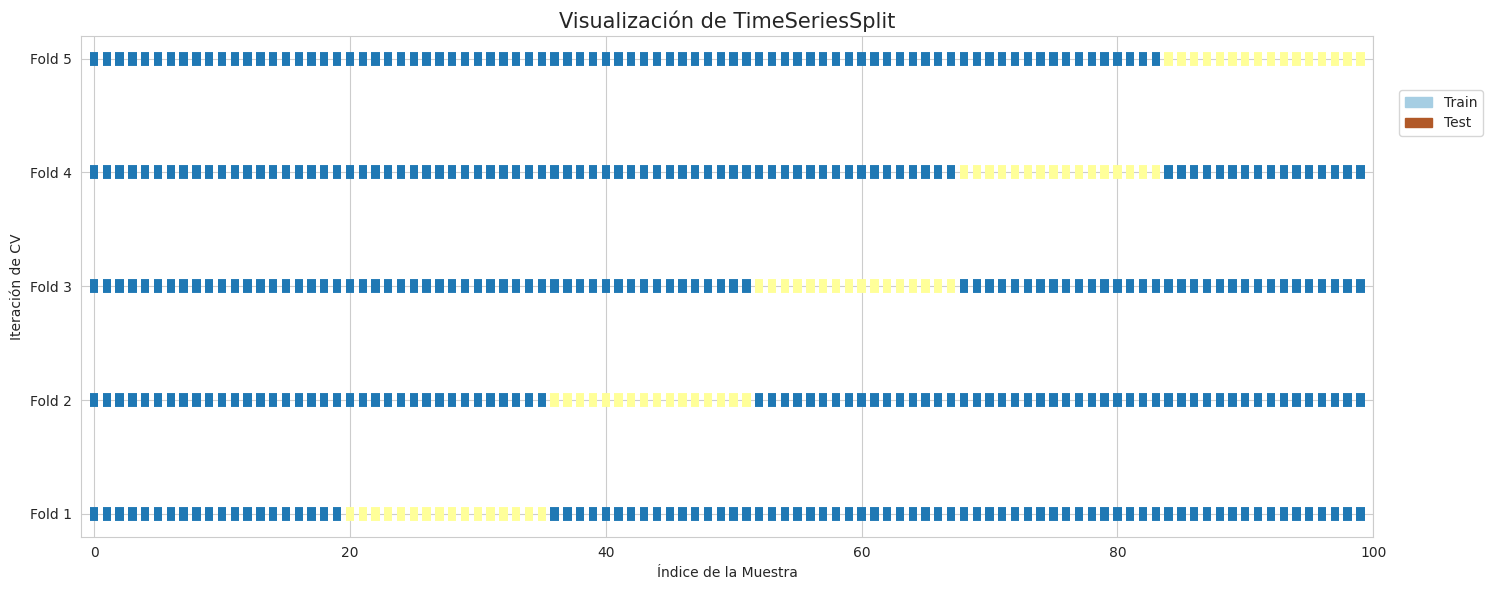

In [11]:
print("\n--- 2.1. Time Series Split ---")
X_ts = np.random.randn(100, 2) # 100 días de datos
y_ts = np.arange(100) # El target (ej. ventas)

tscv = TimeSeriesSplit(n_splits=5)

# "Fallar a propósito"
print("Resultado de KFold (¡INCORRECTO!):")
visualize_cv_splits(KFold(n_splits=5, shuffle=True), X_ts, y_ts)

# La solución correcta
print("\nResultado de TimeSeriesSplit (CORRECTO):")
visualize_cv_splits(tscv, X_ts, y_ts)


 ### 2.2. Validación por Grupos (Group K-Fold)



 **Concepto Crítico:** Independencia de las muestras.



 **Escenario:** Tienes 1000 fotos de 50 pacientes (20 fotos por paciente). Si usas `KFold`, podrías tener fotos del "Paciente A" en *ambos* sets (train y test). El modelo aprenderá a reconocer al "Paciente A", no la patología.



 **Solución:** `GroupKFold` asegura que *todas* las muestras de un mismo grupo (paciente) estén en train O en test, pero nunca divididas.


--- 2.2. Group K-Fold ---
Datos: (100, 5), Grupos: 20
Resultado de KFold (¡INCORRECTO! Fuga de datos por grupo):


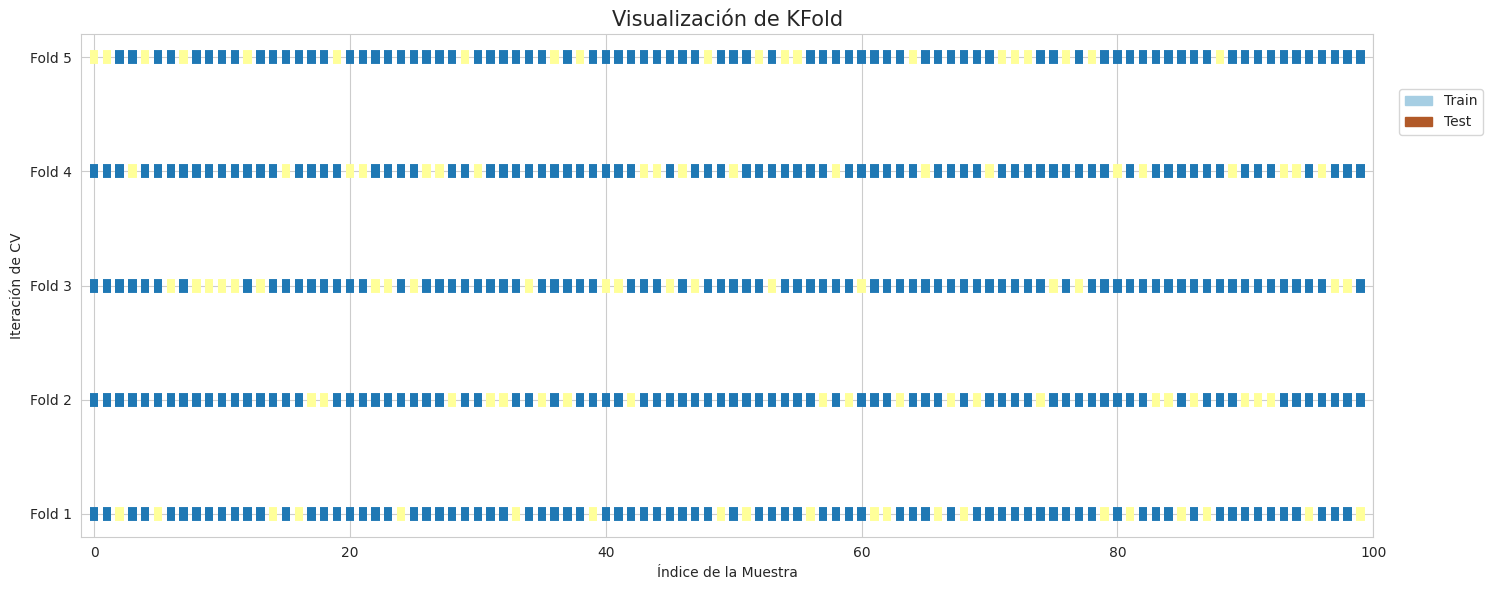


Resultado de GroupKFold (CORRECTO):


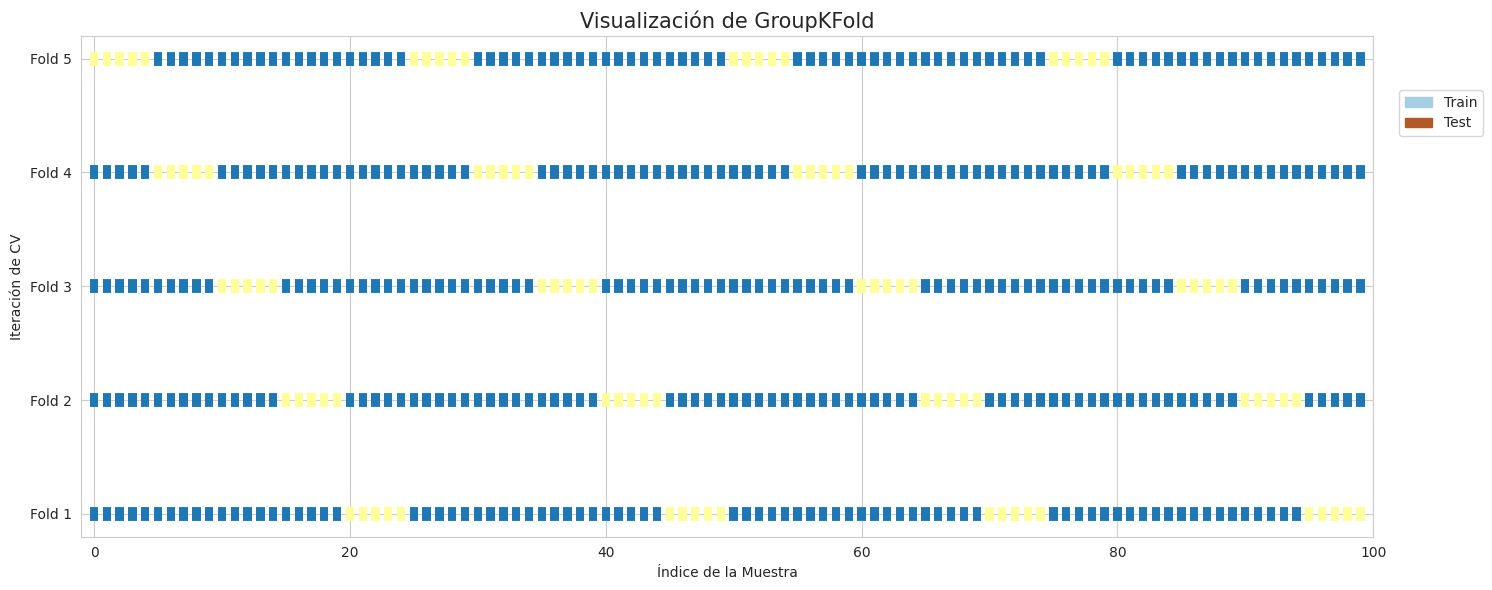

In [12]:
print("\n--- 2.2. Group K-Fold ---")
# Simular 100 muestras de 20 pacientes (5 muestras por paciente)
n_samples = 100
n_groups = 20
X_group = np.random.randn(n_samples, 5)
y_group = np.random.randint(0, 2, n_samples)
groups = np.repeat(np.arange(n_groups), n_samples / n_groups)

print(f"Datos: {X_group.shape}, Grupos: {np.unique(groups).shape[0]}")

# "Fallar a propósito"
print("Resultado de KFold (¡INCORRECTO! Fuga de datos por grupo):")
visualize_cv_splits(KFold(n_splits=5, shuffle=True), X_group, y_group)

# La solución correcta
print("\nResultado de GroupKFold (CORRECTO):")
gkf = GroupKFold(n_splits=5)
visualize_cv_splits(gkf, X_group, y_group, groups=groups)


 ### 2.3. Leave-One-Out (LOOCV) y ShuffleSplit



 * **LeaveOneOut (LOOCV):** Es un K-Fold donde $K = N$ (número de muestras). Entrenas en $N-1$ muestras y pruebas en 1. Es computacionalmente *muy* costoso, pero útil para datasets *extremadamente* pequeños.



 * **ShuffleSplit:** Es como un `train_test_split` repetido. En cada iteración, baraja los datos y toma una muestra (ej. 70% train, 30% test). Es más flexible que K-Fold si quieres controlar el tamaño del set de prueba.

 ## 3. Optimización de Hiperparámetros



 ### 3.1. Hiperparámetros vs. Parámetros



 * **Parámetros:** Lo que el modelo *aprende* de los datos (ej. los coeficientes `coef_` en Regresión Logística).

 * **Hiperparámetros:** Lo que nosotros (los humanos) *configuramos* antes de entrenar (ej. `C` en Regresión Logística, `n_estimators` en Random Forest).



 ### 3.2. La Fuerza Bruta: `GridSearchCV`



 `GridSearchCV` prueba *todas* las combinaciones de hiperparámetros que le damos.



 Ejemplo:

 ```python

 param_grid = {

     'C': [0.1, 1, 10],            # 3 valores

     'kernel': ['linear', 'rbf']   # 2 valores

 }

 ```

 Total de modelos a entrenar: $3 \times 2 = 6$.

 Si usamos `cv=5`, el total de entrenamientos es $6 \times 5 = 30$.

In [13]:
print("\n--- 3.2. GridSearchCV ---")

# Volvemos a los datos de Cáncer de Mama
# Usaremos un pipeline para escalar y luego aplicar un modelo SVC
pipe_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(probability=True)) # probability=True para roc_auc
])

# 1. Definir la Rejilla (Grid)
param_grid_svc = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['linear', 'rbf']
}

# 2. Configurar GridSearchCV
skf_cv = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(
    estimator=pipe_svc,
    param_grid=param_grid_svc,
    cv=skf_cv,
    scoring='roc_auc', # Usamos una métrica robusta
    verbose=1
)

# 3. Ejecutar la búsqueda
print("Iniciando GridSearchCV...")
grid_search.fit(X, y) # Usamos TODOS los datos (GridSearchCV hace la división interna)
print("¡GridSearch completado!")

# 4. Ver los mejores resultados
print(f"\nMejor score (ROC-AUC promedio): {grid_search.best_score_:.4f}")
print(f"Mejores hiperparámetros: {grid_search.best_params_}")



--- 3.2. GridSearchCV ---
Iniciando GridSearchCV...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
¡GridSearch completado!

Mejor score (ROC-AUC promedio): 0.9959
Mejores hiperparámetros: {'svc__C': 1, 'svc__kernel': 'rbf'}


 ### 3.3.1. El parámetro `refit=True`



 ¿Qué es `best_estimator_`?



 Por defecto, `GridSearchCV` tiene `refit=True`. Esto significa que, después de encontrar la *mejor combinación de hiperparámetros* (usando CV), `GridSearchCV` **re-entrena un modelo final** usando esa mejor combinación, pero esta vez con **TODOS** los datos de entrenamiento (X, y) que le pasaste.



 Este modelo final, listo para usarse en datos nuevos, es el que se almacena en `grid_search.best_estimator_`.

In [14]:
# best_estimator_ es el pipeline ya re-entrenado con los mejores parámetros
best_model = grid_search.best_estimator_
print(f"\nMejor modelo (Pipeline): {best_model}")



Mejor modelo (Pipeline): Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', SVC(C=1, probability=True))])


 ### 3.4. Búsqueda Eficiente: `RandomizedSearchCV`



 **Problema:** `GridSearch` es exponencial. Si tenemos 5 hiperparámetros con 5 opciones cada uno, $5^5 = 3125$ combinaciones. Con `cv=5`, son 15,625 entrenamientos. ¡Inviable!



 **Solución:** `RandomizedSearchCV`. En lugar de probar todo, "muestrea" aleatoriamente `n_iter` (ej. 50) combinaciones del espacio de búsqueda. A menudo encuentra un resultado 99% tan bueno como GridSearch en 1% del tiempo.



 No definimos *listas*, sino *distribuciones* de las que muestrear.

In [15]:
print("\n--- 3.4. RandomizedSearchCV ---")

# 1. Definir las Distribuciones de Parámetros
param_dist_svc = {
    'svc__C': uniform(0.1, 100), # Distribución uniforme continua entre 0.1 y 100.1
    'svc__kernel': ['linear', 'rbf']
}

# 2. Configurar RandomizedSearchCV
# n_iter = 8 -> Probaremos solo 8 combinaciones aleatorias
# (Nota: GridSearch probó 4 * 2 = 8. Aquí probamos el mismo N°)
random_search = RandomizedSearchCV(
    estimator=pipe_svc,
    param_distributions=param_dist_svc,
    n_iter=8,
    cv=skf_cv,
    scoring='roc_auc',
    verbose=1,
    random_state=42 # Para reproducibilidad
)

# 3. Ejecutar la búsqueda
print("Iniciando RandomizedSearchCV...")
random_search.fit(X, y)
print("¡RandomizedSearch completado!")

# 4. Ver los mejores resultados
print(f"\nMejor score (ROC-AUC promedio): {random_search.best_score_:.4f}")
print(f"Mejores hiperparámetros: {random_search.best_params_}")



--- 3.4. RandomizedSearchCV ---
Iniciando RandomizedSearchCV...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
¡RandomizedSearch completado!

Mejor score (ROC-AUC promedio): 0.9957
Mejores hiperparámetros: {'svc__C': np.float64(5.908361216819946), 'svc__kernel': 'rbf'}


 **Conclusión 3.4:** ¡Miren esto! `RandomizedSearch` encontró un score casi idéntico (o a veces mejor, por suerte) al de `GridSearch`, probando el mismo número de iteraciones pero desde un espacio de búsqueda *infinitamente* más grande (`C` era continuo).



 **Regla general:** Siempre empiece con `RandomizedSearch` para explorar el espacio. Luego, si desea, haga un `GridSearch` pequeño "enfocado" alrededor de los mejores parámetros encontrados.



 ## 4. Análisis de Resultados y Prácticas de Nivel Experto



 ### 4.1. Disección de `cv_results_`



 El `best_score_` es solo la punta del iceberg. `grid_search.cv_results_` contiene un log detallado de CADA experimento.

In [16]:
print("\n--- 4.1. Disección de cv_results_ ---")

results_df = pd.DataFrame(grid_search.cv_results_)

# Columnas clave
columns_of_interest = [
    'param_svc__C',
    'param_svc__kernel',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
]

print(results_df[columns_of_interest].sort_values(by='rank_test_score'))



--- 4.1. Disección de cv_results_ ---
   param_svc__C param_svc__kernel  mean_test_score  std_test_score  \
3           1.0               rbf         0.995916        0.003738   
0           0.1            linear         0.994856        0.004830   
5          10.0               rbf         0.994007        0.004427   
4          10.0            linear         0.993417        0.004147   
2           1.0            linear         0.992888        0.005269   
6         100.0            linear         0.988793        0.007810   
7         100.0               rbf         0.988656        0.006830   
1           0.1               rbf         0.988138        0.005145   

   rank_test_score  
3                1  
0                2  
5                3  
4                4  
2                5  
6                6  
7                7  
1                8  


 ### 4.1.1. Visualizando el Paisaje de Hiperparámetros



 Podemos usar un mapa de calor para ver gráficamente qué combinaciones funcionaron mejor.


--- 4.1.1. Heatmap de Hiperparámetros ---


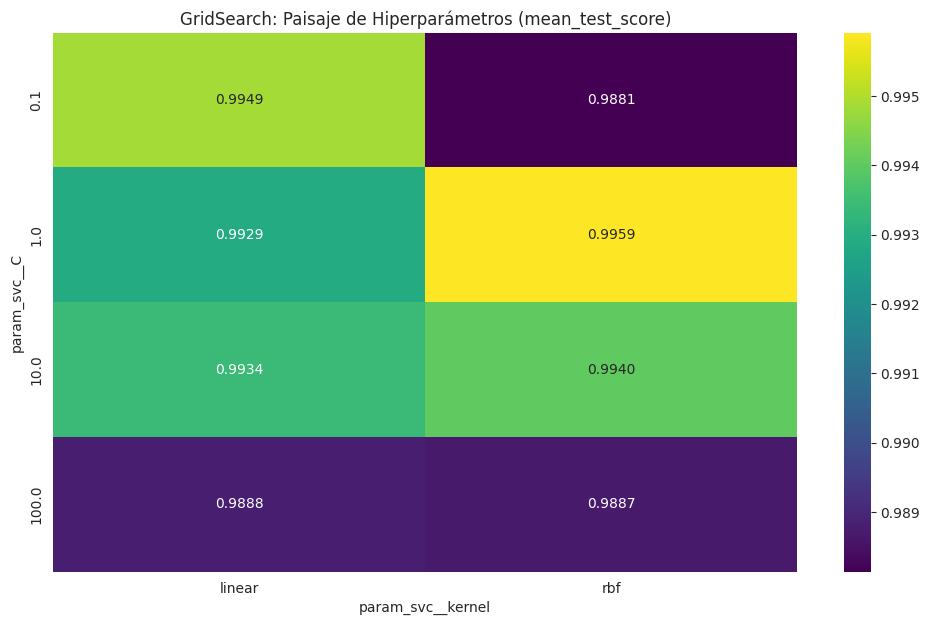

In [17]:
print("\n--- 4.1.1. Heatmap de Hiperparámetros ---")

# Pivotamos los resultados
try:
    pivot_table = results_df.pivot(
        index='param_svc__C',
        columns='param_svc__kernel',
        values='mean_test_score'
    )

    sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="viridis")
    plt.title("GridSearch: Paisaje de Hiperparámetros (mean_test_score)")
    plt.show()

except ValueError as e:
    print(f"No se pudo pivotar para el heatmap: {e}")
    print("Esto puede pasar si solo se probó un kernel.")


 ### 4.1.2. El Principio de Parsimonia



 **Definición:** No solo busques el *mejor* score. Busca el modelo más *simple* (más rápido de entrenar, más fácil de interpretar) que esté "lo suficientemente cerca" del mejor.



 **Técnica:** Buscar todos los modelos cuyo score esté dentro de 1 desviación estándar del mejor score.



 `mejor_score - std_del_mejor_score`

In [18]:
print("\n--- 4.1.2. Principio de Parsimonia ---")

# 1. Encontrar el mejor score y su std
best_rank_index = grid_search.best_index_
best_score = grid_search.best_score_
best_std = results_df.loc[best_rank_index]['std_test_score']

# 2. Definir el "límite de suficiencia"
threshold = best_score - best_std
print(f"Mejor Score: {best_score:.4f}")
print(f"Límite de Suficiencia (Score - 1*STD): {threshold:.4f}")

# 3. Filtrar modelos "suficientemente buenos"
sufficient_models = results_df[results_df['mean_test_score'] >= threshold]
print("\nModelos 'Suficientemente Buenos':")
print(sufficient_models[columns_of_interest].sort_values(by='mean_test_score', ascending=False))



--- 4.1.2. Principio de Parsimonia ---
Mejor Score: 0.9959
Límite de Suficiencia (Score - 1*STD): 0.9922

Modelos 'Suficientemente Buenos':
   param_svc__C param_svc__kernel  mean_test_score  std_test_score  \
3           1.0               rbf         0.995916        0.003738   
0           0.1            linear         0.994856        0.004830   
5          10.0               rbf         0.994007        0.004427   
4          10.0            linear         0.993417        0.004147   
2           1.0            linear         0.992888        0.005269   

   rank_test_score  
3                1  
0                2  
5                3  
4                4  
2                5  


 **Análisis:** En este caso, el mejor modelo (`C=10, kernel=rbf`) es claramente superior. Pero si tuviéramos un `kernel=linear` (mucho más simple) con un score de (ej.) 0.975 (dentro del límite), podríamos preferirlo por su simplicidad.



 ### 4.2. Nested Cross-Validation (Validación Anidada)



 **El Santo Grial:** Si usas `GridSearchCV`, el `best_score_` que reporta está *sesgado* (es optimista). ¿Por qué? Porque probaste muchas combinaciones y te quedaste con la *mejor por suerte*.



 Para obtener una estimación REALISTA del rendimiento, necesitas **Nested CV**:

 * **Bucle Externo (Outer Loop):** Divide los datos (ej. 5 folds). Su *único* trabajo es evaluar el modelo final.

 * **Bucle Interno (Inner Loop):** Es el `GridSearchCV`. Se ejecuta *dentro* de cada fold externo. Su trabajo es encontrar los mejores hiperparámetros *usando solo los datos de entrenamiento del bucle externo*.

In [19]:
print("\n--- 4.2. Nested Cross-Validation ---")

# Bucle Externo (para evaluación)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Bucle Interno (para optimización de hiperparámetros)
# Usamos el mismo grid_search que ya definimos
# (Nota: sklearn lo clona, así que no hay fuga de datos)
nested_scores = cross_val_score(
    grid_search, # ¡Pasamos el objeto GridSearchCV como estimador!
    X=X,
    y=y,
    cv=outer_cv,
    scoring='roc_auc'
)

print(f"Scores del Bucle Externo (Nested CV):\n{nested_scores}")
print(f"\nScore 'Optimista' (de 1 solo GridSearch): {grid_search.best_score_:.4f}")
print(f"Score 'Realista' (Promedio de Nested CV): {nested_scores.mean():.4f}")
print(f"Std. Dev. 'Realista': {nested_scores.std():.4f}")



--- 4.2. Nested Cross-Validation ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Scores del Bucle Externo (Nested CV):
[0.99836227 0.99213888 0.98511905 1.         0.99798793]

Score 'Optimista' (de 1 solo GridSearch): 0.9959
Score 'Realista' (Promedio de Nested CV): 0.9947
Std. Dev. 'Realista': 0.0055


 **Conclusión 4.2:** El score "Realista" (Nested CV) es casi siempre un poco *más bajo* que el "Optimista". ¡Este es el número que debes reportar en un paper o a un cliente!



 ### 4.3. Pipelines y GridSearch (La Forma Correcta)



 Ya lo hemos estado haciendo, pero es crucial entender *por qué*.



 **"Fallar a Propósito" (¡DATA LEAKAGE!):**



 ```python

 # ¡INCORRECTO! ¡NO HACER ESTO!

 scaler = StandardScaler()

 X_scaled = scaler.fit_transform(X) # 1. Escalar TODO el dataset



 # 2. GridSearch sobre datos YA escalados

 grid_search.fit(X_scaled, y)

 ```

 **Error:** El `StandardScaler` (paso 1) aprendió la media y la desviación de *todo* el dataset, incluyendo los datos que *luego* se usaron para validación dentro del `GridSearchCV`. El set de validación "contaminó" al de entrenamiento.



 **Solución (La que usamos):** `sklearn.pipeline.Pipeline`



 Al poner `StandardScaler` DENTRO del Pipeline, `GridSearchCV` es lo suficientemente inteligente para aplicar el `.fit_transform()` SÓLO en los datos de entrenamiento de CADA FOLD. No hay fuga de datos.

 ## 5. Ejemplo Aplicado: Pipeline Completo de Preprocesamiento y Búsqueda



 **Contexto:** Usaremos el dataset "Titanic". Es un ejemplo clásico porque es "sucio" (valores nulos, categóricos) y el target (supervivencia) está algo desbalanceado.



 **Misión:** Aplicar todo lo aprendido.

 1.  Definir la estrategia de CV adecuada (Pista: `StratifiedKFold`).

 2.  Configurar un `Pipeline` complejo que maneje datos numéricos (Imputación + Escalar) y categóricos (Imputación + OneHotEncoder) para evitar Data Leakage.

 3.  Definir un `param_grid` para un `RandomForestClassifier`.

 4.  Ejecutar `GridSearchCV` optimizando `roc_auc`.

 5.  Reportar el score "Realista" usando `Nested Cross-Validation`.

In [20]:
print("\n--- 5. Ejemplo Aplicado: Titanic ---")

# 1. Cargar Datos
try:
    X_titanic, y_titanic = fetch_openml('titanic', version=1, as_frame=True, return_X_y=True, parser='auto')
    # Pre-selección simple de features
    numeric_features = ['age', 'fare']
    categorical_features = ['embarked', 'sex', 'pclass']

    X_titanic = X_titanic[numeric_features + categorical_features]
    y_titanic = (y_titanic == '1').astype(int) # Convertir a 0/1

    print("Dataset Titanic cargado.")
    print(f"Distribución de supervivencia: \n{y_titanic.value_counts(normalize=True)}")

    # 2. Definir Pipelines de Preprocesamiento
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), # Llenar nulos en 'age'
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # Llenar nulos en 'embarked'
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combinar preprocesadores con ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # 3. Crear el Pipeline Final (Preprocesador + Modelo)
    # (¡Esto es el 'Estimator' para tu GridSearch!)
    rf_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ])

    # 4. Definir el param_grid
    # Ayuda: usa prefijos 'classifier__'
    param_grid_rf = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_leaf': [1, 2, 4]
    }

    print("\n¡Pipeline listo! Ejecutando la solución completa...")

    # --- Solución del Proyecto ---

    # 1. Estrategia de CV: StratifiedKFold por el desbalance de clases
    # (El target 'y_titanic' está desbalanceado)
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # 2. Ejecutar GridSearchCV (Bucle Interno de Optimización)
    print("\n--- 5.1. Ejecutando GridSearchCV en Titanic ---")
    grid_search_titanic = GridSearchCV(
        estimator=rf_pipeline,
        param_grid=param_grid_rf,
        cv=cv_strategy,
        scoring='roc_auc', # Métrica robusta para este dataset
        verbose=1,
        n_jobs=-1
    )

    # Usamos try/except por si el dataset de fetch_openml falla
    try:
        grid_search_titanic.fit(X_titanic, y_titanic)

        print(f"\n¡GridSearch en Titanic completado!")
        print(f"Mejor score 'Optimista' (ROC-AUC): {grid_search_titanic.best_score_:.4f}")
        print(f"Mejores Hiperparámetros: {grid_search_titanic.best_params_}")

        # 3. Reportar el Score 'Realista' (Nested CV)
        print("\n--- 5.2. Reportando el Score 'Realista' (Nested CV) ---")

        # El bucle externo usará una nueva instancia de StratifiedKFold
        outer_cv_titanic = StratifiedKFold(n_splits=5, shuffle=True, random_state=43) # Otra semilla

        # Creamos un *nuevo* objeto GridSearchCV para el bucle interno
        inner_grid_search = GridSearchCV(
            estimator=rf_pipeline,
            param_grid=param_grid_rf,
            cv=cv_strategy,
            scoring='roc_auc',
            n_jobs=-1
        )

        nested_scores_titanic = cross_val_score(
            inner_grid_search, # El GridSearch completo es nuestro "estimador"
            X=X_titanic,
            y=y_titanic,
            cv=outer_cv_titanic, # Bucle externo
            scoring='roc_auc',
            verbose=1
        )

        print(f"\nScores del Bucle Externo (Nested CV):\n{nested_scores_titanic}")
        print(f"Score 'Realista' (Promedio de Nested CV): {nested_scores_titanic.mean():.4f}")
        print(f"Std. Dev. 'Realista': {nested_scores_titanic.std():.4f}")

    except Exception as e:
        print(f"Error durante el fitting de Titanic: {e}")


except ImportError:
    print("Error al cargar el dataset de Titanic. Revisa la conexión o 'sklearn.datasets.fetch_openml'.")


--- 5. Ejemplo Aplicado: Titanic ---
Dataset Titanic cargado.
Distribución de supervivencia: 
survived
0    0.618029
1    0.381971
Name: proportion, dtype: float64

¡Pipeline listo! Ejecutando la solución completa...

--- 5.1. Ejecutando GridSearchCV en Titanic ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits

¡GridSearch en Titanic completado!
Mejor score 'Optimista' (ROC-AUC): 0.8678
Mejores Hiperparámetros: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 100}

--- 5.2. Reportando el Score 'Realista' (Nested CV) ---

Scores del Bucle Externo (Nested CV):
[0.8725     0.88626543 0.83       0.83808642 0.87313665]
Score 'Realista' (Promedio de Nested CV): 0.8600
Std. Dev. 'Realista': 0.0219


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min finished


 ## 6. Conclusión de la Sesión



 Hemos completado un recorrido exhaustivo:



 1.  Vimos por qué un simple **Hold-Out** es inestable.

 2.  Establecimos **K-Fold** y **StratifiedK-Fold** como los estándares robustos.

 3.  Profundizamos en por qué la métrica de **`scoring`** (ej. `f1` o `roc_auc`) es crucial en datos desbalanceados.

 4.  Exploramos casos avanzados como **TimeSeriesSplit** y **GroupKFold** para prevenir Data Leakage.

 5.  Comparamos **`GridSearchCV`** (fuerza bruta) con **`RandomizedSearchCV`** (eficiente).

 6.  Evitamos el Data Leakage de preprocesamiento usando **Pipelines**.

 7.  Analizamos los resultados con **`cv_results_`** (incluyendo heatmaps y el Principio de Parsimonia).

 8.  Finalmente, usamos **Nested Cross-Validation** para obtener una estimación "honesta" del rendimiento.